In [94]:
import uproot
import awkward as ak
import numpy as np
from reco.plotting import plot_event, plot_trackster
from reco.evaluation import bcubed, f_score
from reco.event import get_trackster_map
from reco.energy import get_energy_map
import matplotlib.pyplot as plt
%matplotlib inline

file_name = "~/data/close_by_two_pions_15cm/new_ntuples_14955802_28.root"

tracksters = uproot.open({file_name: "ticlNtuplizer/tracksters"})
simtracksters = uproot.open({file_name: "ticlNtuplizer/simtrackstersSC"})
associations = uproot.open({file_name: "ticlNtuplizer/associations"})

Tracksters reco: 48, tracksters sim: 2


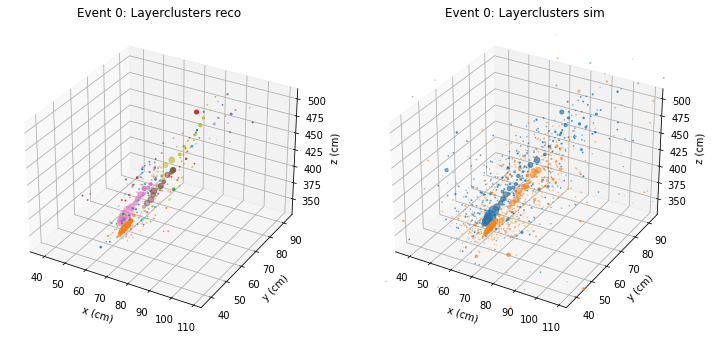

In [95]:
eid = 0

t_indexes = tracksters["vertices_indexes"].array()[eid]
t_energy = tracksters["vertices_energy"].array()[eid]
v_multi = tracksters["vertices_multiplicity"].array()[eid]
st_indexes = simtracksters["stsSC_vertices_indexes"].array()[eid]
st_energy = simtracksters["stsSC_vertices_energy"].array()[eid]
sv_multi = simtracksters["stsSC_vertices_multiplicity"].array()[eid]

print(f"Tracksters reco: {len(t_indexes)}, tracksters sim: {len(st_indexes)}")
plot_event(tracksters, simtracksters, eid, legend=False)

In [96]:
# precompute LC -> Trackster mapping
i2rt = get_trackster_map(t_indexes, v_multi)
i2st = get_trackster_map(st_indexes, sv_multi)

# precompute LC -> Energy mapping (same for all tracksters the LC is in)
te_map = get_energy_map(t_indexes, t_energy, v_multi)     
ste_map = get_energy_map(st_indexes, st_energy, sv_multi)

t_vertices = ak.flatten(t_indexes)
st_vertices = ak.flatten(st_indexes)    # include noise

precision = bcubed(t_vertices, t_indexes, i2rt, i2st, e_map=te_map)
recall = bcubed(st_vertices, st_indexes, i2st, i2rt, e_map=ste_map)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {f_score(precision, recall):.2f}")

Precision: 0.89, Recall: 0.02, F-score: 0.05


## k-means

In [97]:
from sklearn.cluster import KMeans

x_bary = tracksters["barycenter_x"].array()[eid]
y_bary = tracksters["barycenter_y"].array()[eid]
z_bary = tracksters["barycenter_z"].array()[eid]

In [98]:
X = np.array([x_bary, y_bary, z_bary]).T

In [99]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X)

In [100]:
def remap_reco_by_label(vi, vx, vy, vz, ve, labels):
    h = max(labels) + 1
    mi = []
    mx = []
    my = []
    mz = []
    me = []
    mm = []

    for i in range(h):
        mi.append([])
        mx.append([])
        my.append([])
        mz.append([])
        me.append([])
        mm.append([])

    for l, i, x, y, z, e in zip(labels, vi, vx, vy, vz, ve):
        mi[l] += list(i)
        mx[l] += list(x)
        my[l] += list(y)      
        mz[l] += list(z)      
        me[l] += list(e)
        mm[l] += [1] * len(i)

    return ak.Array(mi), mx, my, mz, me, mm

ri, rx, ry, rz, re, rm = remap_reco_by_label(
    tracksters["vertices_indexes"].array()[eid],
    tracksters["vertices_x"].array()[eid],
    tracksters["vertices_y"].array()[eid],
    tracksters["vertices_z"].array()[eid],
    tracksters["vertices_energy"].array()[eid],
    kmeans.labels_)

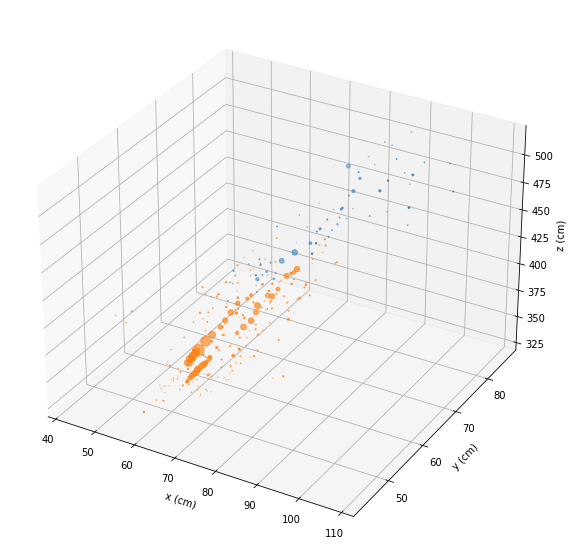

In [101]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("x (cm)")
ax.set_ylabel("y (cm)")
ax.set_zlabel("z (cm)")

for i, x, y, z, e in zip(range(len(rx)), rx, ry, rz, re):
    plot_trackster(ax, i, x, y, z, e)

plt.show()

In [102]:
# precompute LC -> Trackster mapping
i2rt = get_trackster_map(ri, rm)
i2st = get_trackster_map(st_indexes, sv_multi)

# precompute LC -> Energy mapping (same for all tracksters the LC is in)
re_map = get_energy_map(ri, re, rm)     

precision = bcubed(t_vertices, ri, i2rt, i2st, e_map=re_map)
recall = bcubed(st_vertices, st_indexes, i2st, i2rt, e_map=ste_map)
print(f"Precision: {precision:.2f}, Recall: {recall:.2f}, F-score: {f_score(precision, recall):.2f}")

Precision: 0.88, Recall: 0.24, F-score: 0.37
